# rand health insurance – table 2 w/ causalpfn

_pull table 2 numbers straight from the aron-dine/einav/finkelstein (2013) pdf, run causalpfn with the rand hie data, and line up the results._

In [1]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import pdfplumber
import torch
from causalpfn import ATEEstimator, CATEEstimator
import causalpfn.causal_estimator as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor

# keep mac runs stable
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

# paths
RAND_DIR = Path("/Users/richardguo/csc494-spatialpfn/economics/rand_hi")
PDF_PATH = RAND_DIR / "2013-the-rand-health-insurance-experiment-three-decades-later.pdf"
PLAN_PATH = RAND_DIR / "ICPSR_06439" / "DS0160" / "06439-0160-Data.dta"
EXP_PATH = RAND_DIR / "ICPSR_06439" / "DS0163" / "06439-0163-Data.dta"
OUTDIR = RAND_DIR / "results"
OUTDIR.mkdir(parents=True, exist_ok=True)
OUT_CSV = OUTDIR / "rand_hi_causalpfn_notebook.csv"

# plan group mapping (built to match table 2 person-year counts)
PLAN_GROUPS: dict[str, set[int]] = {
    "free": {11},
    "coinsurance_25": {16, 14, 8},
    "mixed": {6, 5},
    "coinsurance_50": {7, 17},
    "deductible": {13, 2},
    "coinsurance_95": {10, 15, 18, 19, 1, 4, 3, 9},
}
BASE_PLAN = "free"

# baseline covariates from the demographic file
COVARIATES = [
    "AGE",
    "SEX",
    "RACE",
    "ETHNOS",
    "MARSTAT",
    "ECOLLEGE",
    "INCOME1",
    "INCOME2",
    "TINC",
    "TINCCAT",
    "HSELFREP",
    "PAINBAS",
    "WORRYBAS",
    "HOSP",
]

DEVICE = "cpu"
TEST_FRAC = 0.2
N_SPLITS = int(os.getenv("RAND_HI_SPLITS", "6"))
BASE_SEED = 2025

# patch causalpfn weak learner to avoid tiny leaves on small splits
def _safe_train_weak_learner(self, X, t, y) -> GradientBoostingRegressor:
    self.t_transformer = OneHotEncoder(sparse_output=False, categories="auto", drop="first")
    T = self.t_transformer.fit_transform(t.reshape(-1, 1))
    self._d_t = (T.shape[1],)
    feat_arr = np.concatenate((X, 1 - np.sum(T, axis=1).reshape(-1, 1), T), axis=1)
    min_leaf = max(1, int(X.shape[0] / 100))
    self.stratifier = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=min_leaf,
        random_state=111,
    )
    self.stratifier.fit(feat_arr, y)

ce.CausalEstimator._train_weak_learner = _safe_train_weak_learner


/Users/richardguo/.pyenv/versions/3.11.8/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# grab table 2 benchmarks from the pdf
import re

def parse_table2(pdf_path: Path) -> pd.DataFrame:
    with pdfplumber.open(pdf_path) as pdf:
        raw = pdf.pages[7].extract_text()
    lines = [ln.strip() for ln in raw.split("\n") if ln.strip()]

    def clean_line(txt: str) -> str:
        return txt.replace("–", "-").replace("−", "-")

    label_map = {
        "free": "Constant",
        "coinsurance_25": "25% Coinsurance",
        "mixed": "Mixed Coinsurance",
        "coinsurance_50": "50% Coinsurance",
        "deductible": "Individual Deductible",
        "coinsurance_95": "95% Coinsurance",
    }
    rows: list[dict] = []
    for plan_key, marker in label_map.items():
        line = next((clean_line(ln) for ln in lines if ln.startswith(marker)), None)
        if line is None:
            continue
        nums = re.findall(r"[-]?\s*\d+[\d,]*\.?\d*", line)
        if len(nums) > 6:
            nums = nums[-6:]
        vals = [float(n.replace(" ", "").replace(",", "")) for n in nums[:6]]
        rows.append(
            {
                "plan": plan_key,
                "share_any": vals[0],
                "spend_total": vals[1],
                "share_inpatient": vals[2],
                "spend_inpatient": vals[3],
                "share_outpatient": vals[4],
                "spend_outpatient": vals[5],
            }
        )
    return pd.DataFrame(rows)

bench_df = parse_table2(PDF_PATH)
bench_df

,plan,share_any,spend_total,share_inpatient,spend_inpatient,share_outpatient,spend_outpatient
0,free,0.931,2170.0,0.103,827.0,0.930,1343.0
1,coinsurance_25,-0.079,-648.0,-0.022,-229.0,-0.078,-420.0
2,mixed,-0.053,-377.0,-0.018,21.0,-0.053,-398.0
3,coinsurance_50,-0.100,-535.0,-0.031,4.0,-0.100,-539.0
4,deductible,-0.124,-473.0,-0.006,-67.0,-0.125,-406.0
5,coinsurance_95,-0.170,-845.0,-0.024,-217.0,-0.171,-629.0


In [3]:
# load plan assignments + annual expenditures
plan_df = pd.read_stata(PLAN_PATH, convert_categoricals=False)
plan_df = plan_df[plan_df["INSTAT"] == "1"].copy()
for col in COVARIATES:
    plan_df[col] = pd.to_numeric(plan_df[col], errors="coerce")
plan_df["PLAN"] = pd.to_numeric(plan_df["PLAN"], errors="coerce")

exp_df = pd.read_stata(EXP_PATH, convert_categoricals=False)
for col in ["INPDOL", "OUTPDOL", "MEDDOL", "POSMED", "POSINP"]:
    exp_df[col] = pd.to_numeric(exp_df[col], errors="coerce")

merged = exp_df.merge(plan_df[["PERSON", "PLAN"] + COVARIATES], on="PERSON", how="left")

# map plan codes into table-2-style bins
def to_plan_group(plan_code: float) -> str | None:
    try:
        code_int = int(plan_code)
    except Exception:
        return None
    for name, codes in PLAN_GROUPS.items():
        if code_int in codes:
            return name
    return None

merged["plan_group"] = merged["PLAN"].apply(to_plan_group)
merged = merged[merged["plan_group"].notna()].reset_index(drop=True)

# outcomes
merged["any_spending"] = ((merged["POSMED"] > 0) | (merged["MEDDOL"] > 0)).astype(float)
merged["any_inpatient"] = ((merged["POSINP"] > 0) | (merged["INPDOL"] > 0)).astype(float)
merged["any_outpatient"] = (merged["OUTPDOL"] > 0).astype(float)
for col in ["MEDDOL", "INPDOL", "OUTPDOL"]:
    merged[col] = merged[col].fillna(0.0)

merged.shape, merged["plan_group"].value_counts()


((21127, 43),
 plan_group
 free              7086
 deductible        4428
 coinsurance_95    4202
 coinsurance_25    2361
 mixed             1696
 coinsurance_50    1354
 Name: count, dtype: int64)

In [4]:
# helpers

def set_all_seeds(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def split_idx(n: int, test_frac: float, seed: int):
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    n_test = max(1, int(round(test_frac * n)))
    te = idx[:n_test]
    tr = idx[n_test:]
    return tr, te


def standardize_train_apply(Xtr: np.ndarray, Xte: np.ndarray, eps: float = 1e-8):
    mu = Xtr.mean(axis=0, keepdims=True)
    sd = Xtr.std(axis=0, keepdims=True)
    sd = np.where(sd < eps, 1.0, sd)
    return (Xtr - mu) / sd, (Xte - mu) / sd


def ate_diff_in_means(Y: np.ndarray, T: np.ndarray) -> float:
    t1 = T == 1
    t0 = T == 0
    if t1.sum() == 0 or t0.sum() == 0:
        return float("nan")
    return float(Y[t1].mean() - Y[t0].mean())


def build_features(df: pd.DataFrame) -> np.ndarray:
    X = df[COVARIATES].copy()
    for c in X.columns:
        if X[c].isna().any():
            X[c] = X[c].fillna(X[c].median())
    return X.astype(np.float32).to_numpy()


def run_plan_outcome(df: pd.DataFrame, plan_key: str, y_col: str, outcome_label: str) -> list[dict]:
    keep = df["plan_group"].isin({BASE_PLAN, plan_key}) & df[y_col].notna()
    dfk = df.loc[keep].copy().reset_index(drop=True)
    if dfk.empty:
        return []
    T = (dfk["plan_group"] == plan_key).astype(np.float32).to_numpy()
    Y = dfk[y_col].astype(np.float32).to_numpy()
    X = build_features(dfk)
    n = X.shape[0]
    p = X.shape[1]
    n_treat = int((T == 1).sum())
    n_ctrl = int((T == 0).sum())
    rows: list[dict] = []
    for split in range(N_SPLITS):
        seed = BASE_SEED + 1000 * split + hash(plan_key + y_col) % 997
        set_all_seeds(seed)
        tr_idx, te_idx = split_idx(n, TEST_FRAC, seed)
        Xtr, Xte = X[tr_idx], X[te_idx]
        Ttr, Tte = T[tr_idx], T[te_idx]
        Ytr, Yte = Y[tr_idx], Y[te_idx]
        Xtr, Xte = standardize_train_apply(Xtr, Xte)
        ate_est = ATEEstimator(device=DEVICE)
        cate_est = CATEEstimator(device=DEVICE)
        ate_est.fit(Xtr, Ttr, Ytr)
        cate_est.fit(Xtr, Ttr, Ytr)
        ate_hat = float(ate_est.estimate_ate())
        cate_hat = np.asarray(cate_est.estimate_cate(Xte), dtype=np.float32)
        diff_dm = ate_diff_in_means(Yte, Tte)
        rows.append(
            {
                "plan": plan_key,
                "outcome": outcome_label,
                "y_col": y_col,
                "split": split,
                "n_used": int(n),
                "p": int(p),
                "treated": n_treat,
                "control": n_ctrl,
                "ate_hat": ate_hat,
                "diff_in_means_test": diff_dm,
                "cate_mean": float(cate_hat.mean()),
                "cate_std": float(cate_hat.std()),
                "device": DEVICE,
                "seed": int(seed),
                "test_frac": float(TEST_FRAC),
            }
        )
    return rows


In [5]:
# run causalpfn for each plan vs free
OUTCOME_SPECS = [
    ("any_spending", "share_any"),
    ("MEDDOL", "spend_total"),
    ("any_inpatient", "share_inpatient"),
    ("INPDOL", "spend_inpatient"),
    ("any_outpatient", "share_outpatient"),
    ("OUTPDOL", "spend_outpatient"),
]

all_rows: list[dict] = []
for plan_key in PLAN_GROUPS:
    if plan_key == BASE_PLAN:
        continue
    for y_col, outcome_label in OUTCOME_SPECS:
        print(f"running {plan_key} {outcome_label} ...")
        rows = run_plan_outcome(merged, plan_key, y_col, outcome_label)
        all_rows.extend(rows)

results_df = pd.DataFrame(all_rows)
results_df.to_csv(OUT_CSV, index=False)
print(f"saved splits to {OUT_CSV}")
results_df.head()


running coinsurance_25 share_any ...
running coinsurance_25 spend_total ...
running coinsurance_25 share_inpatient ...
running coinsurance_25 spend_inpatient ...
running coinsurance_25 share_outpatient ...
running coinsurance_25 spend_outpatient ...
running mixed share_any ...
running mixed spend_total ...
running mixed share_inpatient ...
running mixed spend_inpatient ...
running mixed share_outpatient ...
running mixed spend_outpatient ...
running coinsurance_50 share_any ...
running coinsurance_50 spend_total ...
running coinsurance_50 share_inpatient ...
running coinsurance_50 spend_inpatient ...
running coinsurance_50 share_outpatient ...
running coinsurance_50 spend_outpatient ...
running deductible share_any ...
running deductible spend_total ...
running deductible share_inpatient ...
running deductible spend_inpatient ...
running deductible share_outpatient ...
running deductible spend_outpatient ...
running coinsurance_95 share_any ...
running coinsurance_95 spend_total ...
ru

,plan,outcome,y_col,split,n_used,p,treated,control,ate_hat,diff_in_means_test,cate_mean,cate_std,device,seed,test_frac
0,coinsurance_25,share_any,any_spending,0,9447,14,2361,7086,-0.150640,-0.225348,-0.119044,0.116845,cpu,2492,0.2
1,coinsurance_25,share_any,any_spending,1,9447,14,2361,7086,-0.162017,-0.207938,-0.129689,0.115815,cpu,3492,0.2
2,coinsurance_25,share_any,any_spending,2,9447,14,2361,7086,-0.157926,-0.180682,-0.123119,0.116202,cpu,4492,0.2
3,coinsurance_25,share_any,any_spending,3,9447,14,2361,7086,-0.138949,-0.224395,-0.113694,0.125357,cpu,5492,0.2
4,coinsurance_25,share_any,any_spending,4,9447,14,2361,7086,-0.140100,-0.246226,-0.112463,0.118686,cpu,6492,0.2


In [6]:
# aggregate across splits
agg = pd.DataFrame()
if len(results_df):
    agg = (
        results_df.groupby(["plan", "outcome"])
        .agg(
            ate_mean=("ate_hat", "mean"),
            ate_std=("ate_hat", "std"),
            diff_in_means_test=("diff_in_means_test", "mean"),
            cate_mean=("cate_mean", "mean"),
            cate_std=("cate_std", "mean"),
            n_used=("n_used", "first"),
            treated=("treated", "first"),
            control=("control", "first"),
            splits=("split", "count"),
        )
        .reset_index()
    )
    display(agg)
else:
    print("no results produced")


,plan,outcome,ate_mean,ate_std,diff_in_means_test,cate_mean,cate_std,n_used,treated,control,splits
0,coinsurance_25,share_any,-0.148814,0.009642,-0.221017,-0.118493,0.116355,9447,2361,7086,6
1,coinsurance_25,share_inpatient,-0.026063,0.002392,-0.021833,-0.008943,0.052400,9447,2361,7086,6
2,coinsurance_25,share_outpatient,-0.161317,0.006140,-0.215761,-0.125861,0.120777,9447,2361,7086,6
3,coinsurance_25,spend_inpatient,-77.965762,16.629708,-52.147535,-30.548063,145.536407,9447,2361,7086,6
4,coinsurance_25,spend_outpatient,-49.774042,2.013282,-49.527761,-35.502876,46.241680,9447,2361,7086,6
5,coinsurance_25,spend_total,-162.932332,10.087814,-69.725438,-104.101224,217.131966,9447,2361,7086,6
6,coinsurance_50,share_any,-0.078350,0.005367,-0.078880,-0.077114,0.072555,8440,1354,7086,6
7,coinsurance_50,share_inpatient,-0.020711,0.004221,-0.007554,-0.017566,0.037035,8440,1354,7086,6
8,coinsurance_50,share_outpatient,-0.082354,0.004781,-0.063446,-0.081003,0.073864,8440,1354,7086,6
9,coinsurance_50,spend_inpatient,-34.612145,15.283737,-47.716731,-11.649013,108.577488,8440,1354,7086,6


In [7]:
# compare pdf coefficients vs causalpfn
if len(bench_df) and len(results_df):
    agg_comp = (
        results_df.groupby(["plan", "outcome"])
        .agg(ate_mean=("ate_hat", "mean"))
        .reset_index()
    )
    bench_effects = bench_df[bench_df["plan"] != BASE_PLAN]
    bench_long = bench_effects.melt(id_vars=["plan"], var_name="outcome", value_name="pdf_effect")
    comp = agg_comp.merge(bench_long, on=["plan", "outcome"], how="left")
    comp = comp[["plan", "outcome", "pdf_effect", "ate_mean"]].sort_values(["plan", "outcome"])
    display(comp)
else:
    print("bench or results missing; run earlier cells")


,plan,outcome,pdf_effect,ate_mean
0,coinsurance_25,share_any,-0.079,-0.148814
1,coinsurance_25,share_inpatient,-0.022,-0.026063
2,coinsurance_25,share_outpatient,-0.078,-0.161317
3,coinsurance_25,spend_inpatient,-229.000,-77.965762
4,coinsurance_25,spend_outpatient,-420.000,-49.774042
5,coinsurance_25,spend_total,-648.000,-162.932332
6,coinsurance_50,share_any,-0.100,-0.078350
7,coinsurance_50,share_inpatient,-0.031,-0.020711
8,coinsurance_50,share_outpatient,-0.100,-0.082354
9,coinsurance_50,spend_inpatient,4.000,-34.612145


,fraction,uplift,qini,score
1884,0.997882,-159.573929,-71010.398438,-1194.816528
1885,0.998412,-159.578903,-71012.617188,-1194.816528
1886,0.998941,-159.976151,-71189.382812,-1323.458496
1887,0.999471,-160.059616,-71226.523438,-1351.309082
1888,1.000000,-160.236343,-71305.164062,-1351.309082


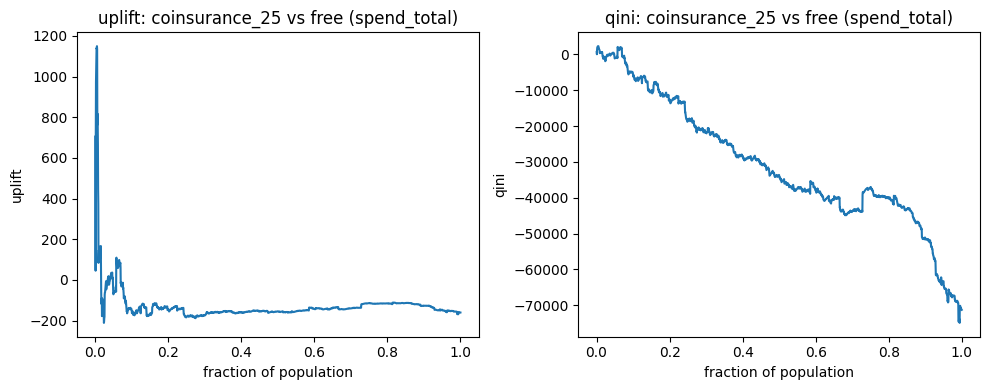

In [9]:
# qini and uplift curves (single split helper)
import matplotlib.pyplot as plt


def qini_uplift_curve(T: np.ndarray, Y: np.ndarray, scores: np.ndarray) -> pd.DataFrame:
    order = np.argsort(-scores)
    T = T[order]
    Y = Y[order]
    scores = scores[order]
    cum_treat = np.cumsum(T)
    cum_ctrl = np.cumsum(1 - T)
    cum_out_treat = np.cumsum(Y * T)
    cum_out_ctrl = np.cumsum(Y * (1 - T))
    with np.errstate(divide="ignore", invalid="ignore"):
        uplift = (cum_out_treat / np.maximum(cum_treat, 1e-9)) - (
            cum_out_ctrl / np.maximum(cum_ctrl, 1e-9)
        )
        qini = cum_out_treat - cum_out_ctrl * (cum_treat / np.maximum(cum_ctrl, 1e-9))
    frac = np.arange(1, len(T) + 1) / len(T)
    return pd.DataFrame({"fraction": frac, "uplift": uplift, "qini": qini, "score": scores})


def run_qini_for_plan(plan_key: str, y_col: str, outcome_label: str, seed: int = 4040):
    keep = merged["plan_group"].isin({BASE_PLAN, plan_key}) & merged[y_col].notna()
    dfk = merged.loc[keep].copy().reset_index(drop=True)
    if dfk.empty:
        print(f"no data for {plan_key}-{outcome_label}")
        return None
    T = (dfk["plan_group"] == plan_key).astype(np.float32).to_numpy()
    Y = dfk[y_col].astype(np.float32).to_numpy()
    X = build_features(dfk)
    set_all_seeds(seed)
    tr_idx, te_idx = split_idx(len(X), TEST_FRAC, seed)
    Xtr, Xte = X[tr_idx], X[te_idx]
    Ttr, Tte = T[tr_idx], T[te_idx]
    Ytr, Yte = Y[tr_idx], Y[te_idx]
    Xtr, Xte = standardize_train_apply(Xtr, Xte)
    cate_est = CATEEstimator(device=DEVICE)
    cate_est.fit(Xtr, Ttr, Ytr)
    scores = np.asarray(cate_est.estimate_cate(Xte), dtype=np.float32)
    curves = qini_uplift_curve(Tte, Yte, scores)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(curves["fraction"], curves["uplift"])
    ax[0].set_title(f"uplift: {plan_key} vs free ({outcome_label})")
    ax[0].set_xlabel("fraction of population")
    ax[0].set_ylabel("uplift")
    ax[1].plot(curves["fraction"], curves["qini"])
    ax[1].set_title(f"qini: {plan_key} vs free ({outcome_label})")
    ax[1].set_xlabel("fraction of population")
    ax[1].set_ylabel("qini")
    plt.tight_layout()
    display(curves.tail())
    return curves

# example calls (tweak as needed)
curves_25_total = run_qini_for_plan("coinsurance_25", "MEDDOL", "spend_total")
# curves_95_total = run_qini_for_plan("coinsurance_95", "MEDDOL", "spend_total")
